## Import Required Modules

We import PyTorch for building neural networks, the MNIST dataset from torchvision, DataLoader for batch processing, and matplotlib/pillow for creating visualizations showing how the model learns over time.

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

## Load and Prepare the MNIST Dataset

We download the MNIST dataset and split it into training and test sets. The ToTensor transform converts images to PyTorch tensors and normalizes pixel values to [0, 1]. We use DataLoader to batch the data (32 samples at a time) and shuffle training data for better learning.

Here's what the first eight digits of the dataset look like:

![alt text](firsteightimages.jpg "Title")

In [63]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 27.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.13MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.83MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.16MB/s]


## Why Normalization?

Normalization scales input values to a consistent range, helping the neural network learn faster and more reliably. 

In [64]:
print("Data is normalized by ToTensor transform (scales to [0, 1])")

Data is normalized by ToTensor transform (scales to [0, 1])


## Build the Neural Network Model

We create a sequential model that flattens 28x28 images into vectors, then passes them through two hidden layers (128 and 64 neurons) with ReLU activation. Dropout layers (30%) randomly disable neurons during training to prevent overfitting. The final layer outputs 10 values (one per digit 0-9).

In [65]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 10)
)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.3, inplace=False)
  (7): Linear(in_features=64, out_features=10, bias=True)
)

Total parameters: 109,386


## Configure Training Components

We set up the Adam optimizer to adjust model weights during training and CrossEntropyLoss to measure prediction errors. Adam is efficient for most deep learning tasks and works well with default settings.

In [66]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

## Setup Training Device

We check if a GPU is available and move the model to it for faster training. If no GPU exists, training runs on CPU. GPUs can speed up training by 10-100x for neural networks.

In [67]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Training on: {device}")

Training on: cpu


## Split Data for Validation

We reserve 10% of training data for validation to monitor overfitting. The validation set helps us see if the model generalizes well to unseen data during training, without touching the final test set.

In [68]:
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

## Prepare Samples for Progress Tracking

Before training, we select 15 test images that we'll use to track the model's predictions across epochs. By using the same images throughout training, we can visualize how the model's predictions improve over time.

In [69]:
# Get a fixed set of test samples for tracking progress
test_samples = []
test_sample_labels = []
for images, labels in test_loader:
    test_samples.append(images)
    test_sample_labels.append(labels)
    if len(test_samples) * 32 >= 15:
        break

test_samples = torch.cat(test_samples)[:15].to(device)
test_sample_labels = torch.cat(test_sample_labels)[:15]

# Store predictions at specific epochs for GIF
epoch_snapshots = []
snapshot_epochs = [1, 3, 5, 7, 10]

## Configure Training Parameters

We set the number of epochs (complete passes through the training data) and create a history dictionary to track training metrics. More epochs allow the model to learn better, but too many can lead to overfitting.

In [70]:
epochs = 10
history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

## Training Phase: Forward and Backward Pass

For each epoch, we iterate through batches of training data. The forward pass computes predictions, the loss measures error, and backpropagation (loss.backward()) calculates gradients. The optimizer then updates weights to reduce the error. We capture predictions at certain epochs to visualize learning progress.

In [71]:
for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    # Calculate epoch metrics
    epoch_loss = train_loss / len(train_loader)
    epoch_acc = train_correct / train_total
    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_acc = val_correct / val_total
    
    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_acc)
    history['val_loss'].append(epoch_val_loss)
    history['val_accuracy'].append(epoch_val_acc)
    
    # Save predictions at specific epochs for visualization
    if (epoch + 1) in snapshot_epochs:
        with torch.no_grad():
            snapshot_preds = model(test_samples)
            epoch_snapshots.append({
                'epoch': epoch + 1,
                'predictions': snapshot_preds.cpu(),
                'accuracy': epoch_acc
            })
    
    print(f"{epoch+1}/{epochs} - loss: {epoch_loss:.4f} - accuracy: {epoch_acc:.4f} - val_loss: {epoch_val_loss:.4f} - val_accuracy: {epoch_val_acc:.4f}")

1/10 - loss: 0.4228 - accuracy: 0.8728 - val_loss: 0.1844 - val_accuracy: 0.9478
2/10 - loss: 0.2076 - accuracy: 0.9390 - val_loss: 0.1322 - val_accuracy: 0.9605
3/10 - loss: 0.1656 - accuracy: 0.9511 - val_loss: 0.1108 - val_accuracy: 0.9670
4/10 - loss: 0.1419 - accuracy: 0.9586 - val_loss: 0.1039 - val_accuracy: 0.9695
5/10 - loss: 0.1297 - accuracy: 0.9612 - val_loss: 0.0909 - val_accuracy: 0.9733
6/10 - loss: 0.1177 - accuracy: 0.9650 - val_loss: 0.0937 - val_accuracy: 0.9708
7/10 - loss: 0.1084 - accuracy: 0.9673 - val_loss: 0.0957 - val_accuracy: 0.9725
8/10 - loss: 0.1044 - accuracy: 0.9684 - val_loss: 0.0939 - val_accuracy: 0.9730
9/10 - loss: 0.0992 - accuracy: 0.9694 - val_loss: 0.0894 - val_accuracy: 0.9740
10/10 - loss: 0.0918 - accuracy: 0.9719 - val_loss: 0.0864 - val_accuracy: 0.9742


Can We Test on a Random Image?

Pick a random image from the test set and see how the model classifies it. 

In [75]:
def test_random_image():
    # Pick a random image from test set
    idx = np.random.randint(0, len(test_dataset))
    image, true_label = test_dataset[idx]
    
    # Get prediction
    model.eval()
    with torch.no_grad():
        image_tensor = image.unsqueeze(0).to(device)
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
    
    predicted_label = output.argmax(1).item()
    confidence = probabilities[predicted_label].item()
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Show the image
    ax1.imshow(image.squeeze(), cmap='gray')
    ax1.set_title(f"True Label: {true_label}\nPredicted: {predicted_label} ({confidence:.1%} confident)", 
                  fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # Show confidence scores for all digits
    digits = list(range(10))
    confidences = probabilities.cpu().numpy()
    colors = ['green' if i == predicted_label else 'skyblue' for i in digits]
    
    ax2.barh(digits, confidences, color=colors)
    ax2.set_xlabel('Confidence', fontsize=12)
    ax2.set_ylabel('Digit', fontsize=12)
    ax2.set_title('Prediction Confidence for Each Digit', fontsize=14, fontweight='bold')
    ax2.set_xlim(0, 1)
    ax2.invert_yaxis()
    
    # Add percentage labels
    for i, (digit, conf) in enumerate(zip(digits, confidences)):
        ax2.text(conf + 0.01, i, f'{conf:.1%}', va='center')
    
    plt.tight_layout()
    plt.show()
    
    return f"Predicted: {predicted_label}, Actual: {true_label}, Correct: {predicted_label == true_label}"


### Run this cell multiple times to test different images. The visualization shows the digit image, the model's prediction, and confidence scores for all 10 possible digits.

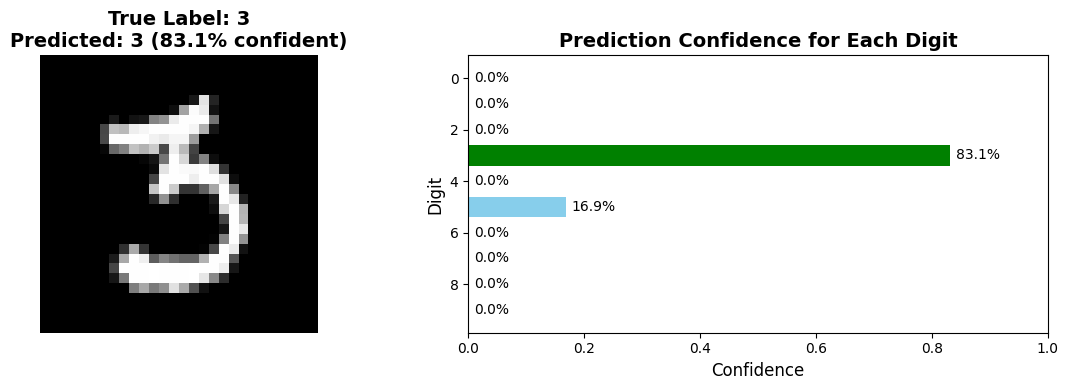

'Predicted: 3, Actual: 3, Correct: True'

In [83]:
test_random_image()

## Save the Trained Model

We save the model's learned parameters to a file so it can be loaded later without retraining. This allows us to use the trained model in other applications like the Streamlit demo app.

In [ ]:
# torch.save(model.state_dict(), 'mnist_model.pth')
# print("Model saved as 'mnist_model.pth'")

Model saved as 'mnist_model.pth'
